In [1]:
import sys, os, warnings
from os import listdir

path2add = os.path.normpath(os.path.abspath(os.path.join(os.path.dirname('__file__'), os.path.pardir, 'utils')))
if (not (path2add in sys.path)) :
    sys.path.append(path2add)

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from pmdarima.arima import auto_arima
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler


from model_utils import ar_baseline_model
from model_utils import arima_model
from model_utils import acf_pacf_test
from model_utils import time_series_analysis
from model_utils import sarimax_model
from model_utils import lstm_model

sns.set_palette("crest")

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

In [2]:
all_paths = []
fol_name = r"C:\Users\angel\Desktop\Data Analysis\Ironhack\Final Bootcamp Project\Smart-Home-Energy-Consumption-Project\data"
for e in os.listdir(fol_name):
    full = os.path.join(fol_name, e)
    if os.path.isfile(full):
        all_paths.append(full)

data = pd.concat(pd.read_csv(f, low_memory=False) for f in all_paths)
data["time"] = pd.to_datetime(data["time"])
data = data.set_index('time').drop(columns="Unnamed: 0", axis=1)
display(data.head())

,use,gen,dishwasher,home office,fridge,wine cellar,garage door,barn,well,microwave,living room,temperature,humidity,visibility,apparenttemperature,pressure,windspeed,cloudcover,windbearing,precipintensity,dewpoint,precipprobability,furnace,kitchen,month,day,weekday,hour,minute
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 05:00:00,0.932833,0.003483,0.000033,0.442633,0.124150,0.006983,0.013083,0.031350,0.001017,0.004067,0.001517,36.14,0.62,10.0,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,0.082617,0.000567,1,1,Friday,5,0
2016-01-01 05:01:00,0.934333,0.003467,0.000000,0.444067,0.124000,0.006983,0.013117,0.031500,0.001017,0.004067,0.001650,36.14,0.62,10.0,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,0.084533,0.000567,1,1,Friday,5,1
2016-01-01 05:02:00,0.931817,0.003467,0.000017,0.446067,0.123533,0.006983,0.013083,0.031517,0.001000,0.004067,0.001650,36.14,0.62,10.0,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,0.083017,0.000617,1,1,Friday,5,2
2016-01-01 05:03:00,1.022050,0.003483,0.000017,0.446583,0.123133,0.006983,0.013000,0.031500,0.001017,0.004067,0.001617,36.14,0.62,10.0,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,0.175417,0.000650,1,1,Friday,5,3
2016-01-01 05:04:00,1.139400,0.003467,0.000133,0.446533,0.122850,0.006850,0.012783,0.031500,0.001017,0.004067,0.001583,36.14,0.62,10.0,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,0.300917,0.000783,1,1,Friday,5,4


### **Univariate Time-Series Prediction**

### *Stationarity and Seasonality*

>##### **Starting point**
>Before implementing a baseline model, I need to verify whether the "use" column meets certain conditions. Models like ARIMA assume stationarity in the data, meaning constant mean and standard deviation without seasonality. 
>
>##### **Impact**
>
>To assess this, I will visually inspect the plotted column and conduct statistical tests such as the Augmented Dickey-Fuller (ADF) test and seasonal decomposition.

In [3]:
use_data_daily = data["use"].resample("D").mean() # I will resample the values by grouping them into diferent intervals 
use_data_weekly = data["use"].resample("W").mean()
use_data_hourly = data["use"].resample("H").mean()

train_data, test_data = train_test_split(use_data_daily, test_size=0.25, shuffle=False)

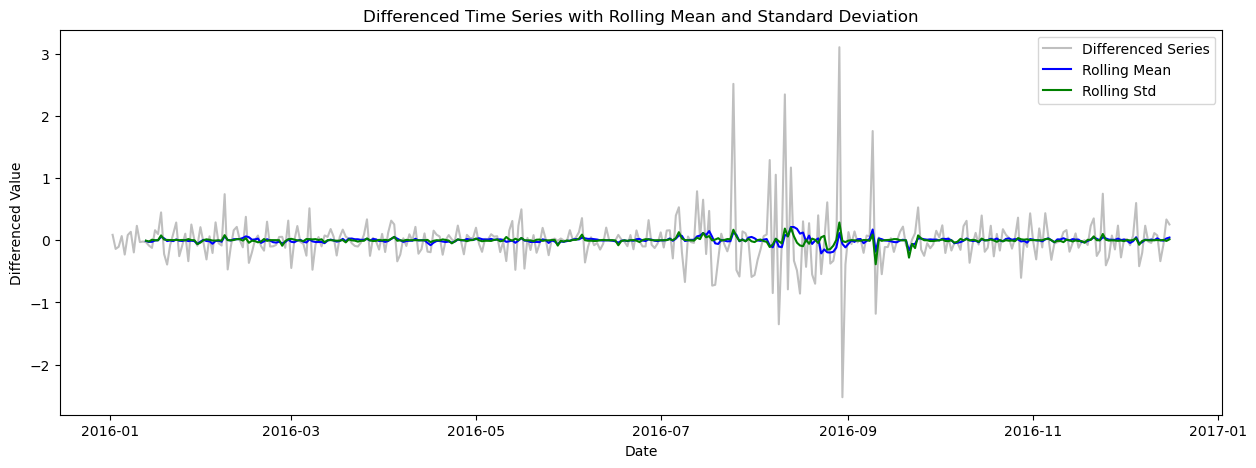

<Figure size 640x480 with 0 Axes>

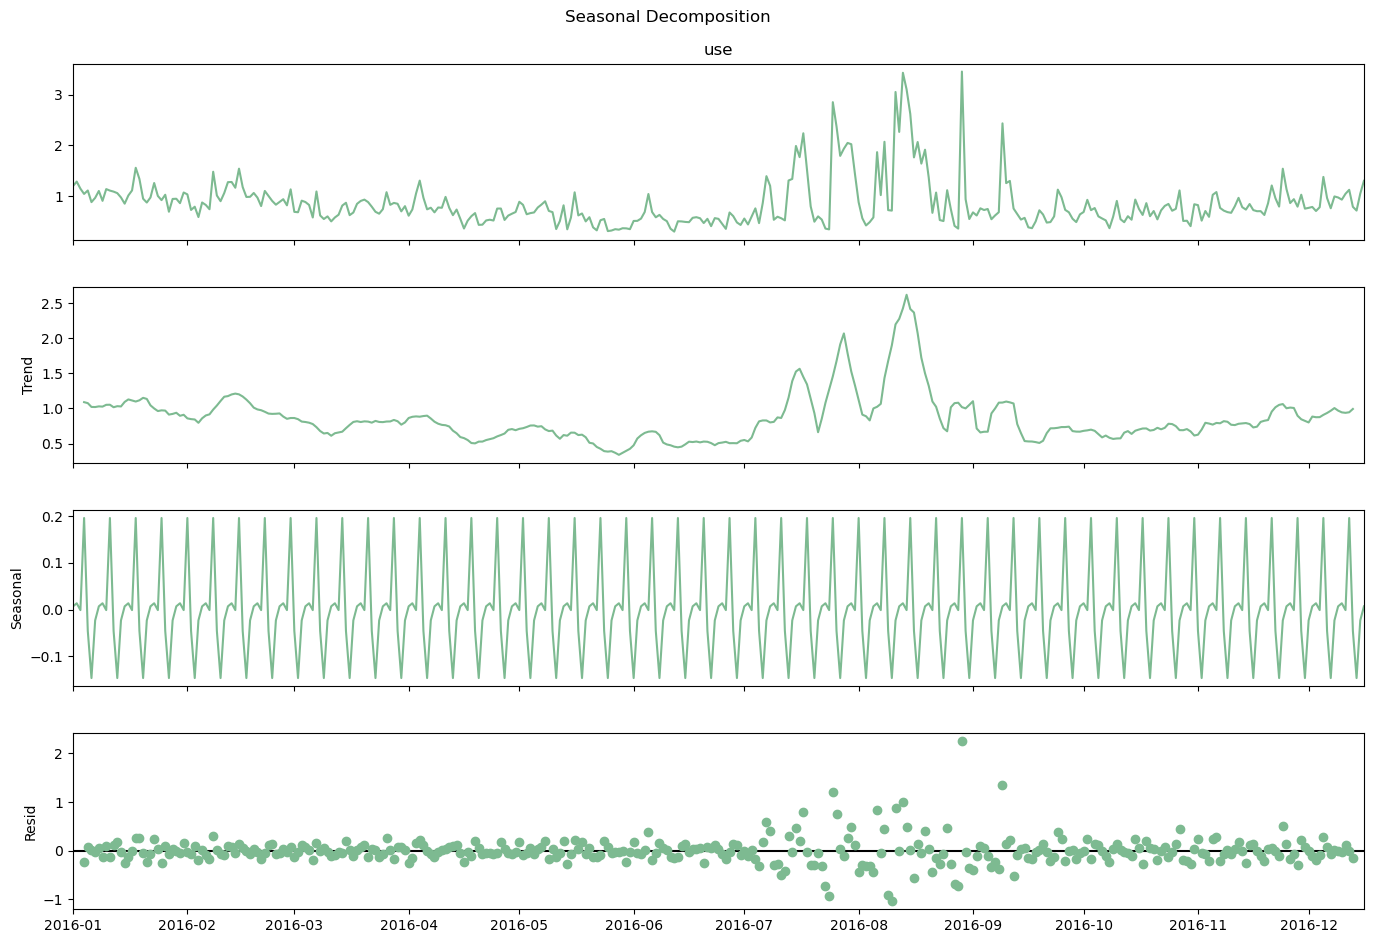

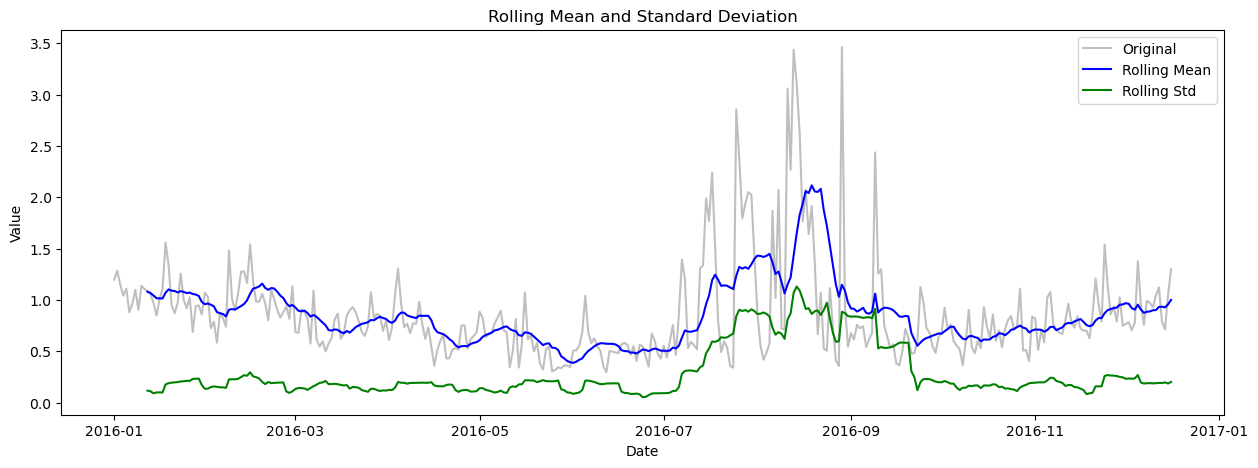

The time series is stationary (reject the null hypothesis)


,ADF Test
ADF Statistic,-2.988003
p-value,0.036030
Critical Value (1%),-3.449730
Critical Value (5%),-2.870079
Critical Value (10%),-2.571319


In [4]:
time_series_analysis(use_data_daily)

>##### **Observations**
>
>* Given that we only have data for a year, it's difficult to ascertain whether seasonality applies to months or yearly seasons. However, the residual component and trend of the seasonal decomposition test suggest the possibility of seasonality, particularly during summer months. Nonetheless, the test captures some weekly seasonality within the year. 
>* The results of the Augmented Dickey-Fuller (ADF) test indicate with a 95% confidence level that the data is indeed stationary. Hence, autoregressive models can be successfully applied and no transformation is needed over the data to do so.
>
>##### **Impact**
>
>* I will proceed to implement an autoregressive model to establish baseline metrics for further improvement.
>* Even though I cannot ascertain seasonality over years, I will maintain the slight assumption that there is a relevant seasonal component. I will delve deeper into this during subsequent steps, especially when multivariate modeling is introduced.

### *Auto Regressive Baseline model*

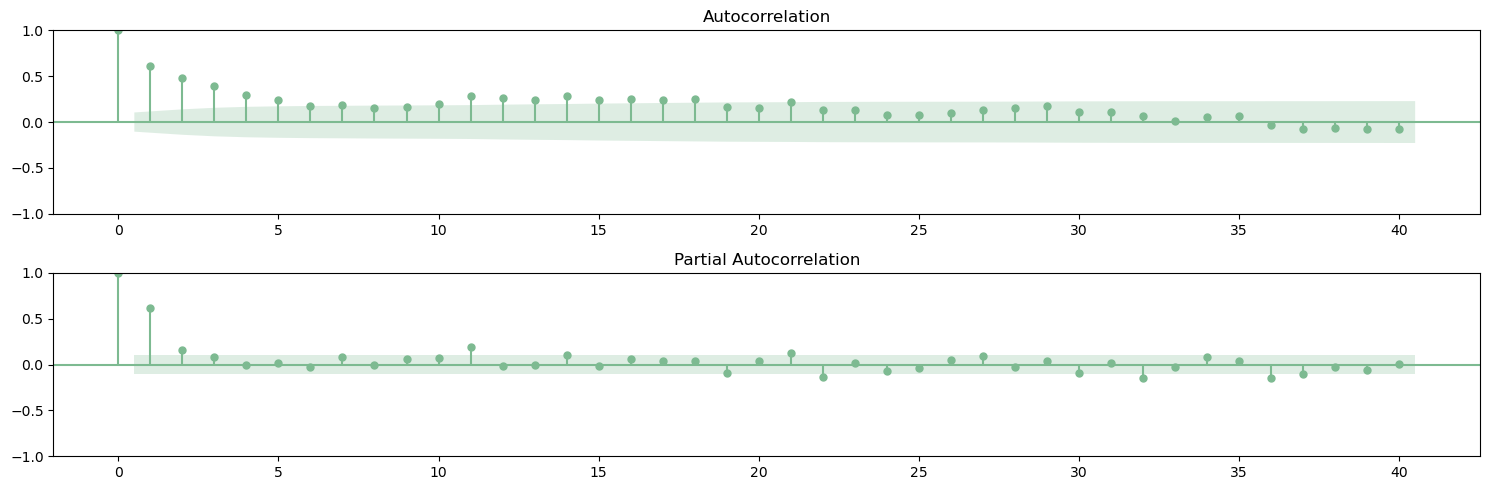

In [5]:
acf_pacf_test(use_data_daily)

> Based on the Partial Autocorrelation Function (PACF) results, it's evident that lags 1, 2, and 11 exhibit significant correlation. Therefore, I will utilize them as the AR parameters.

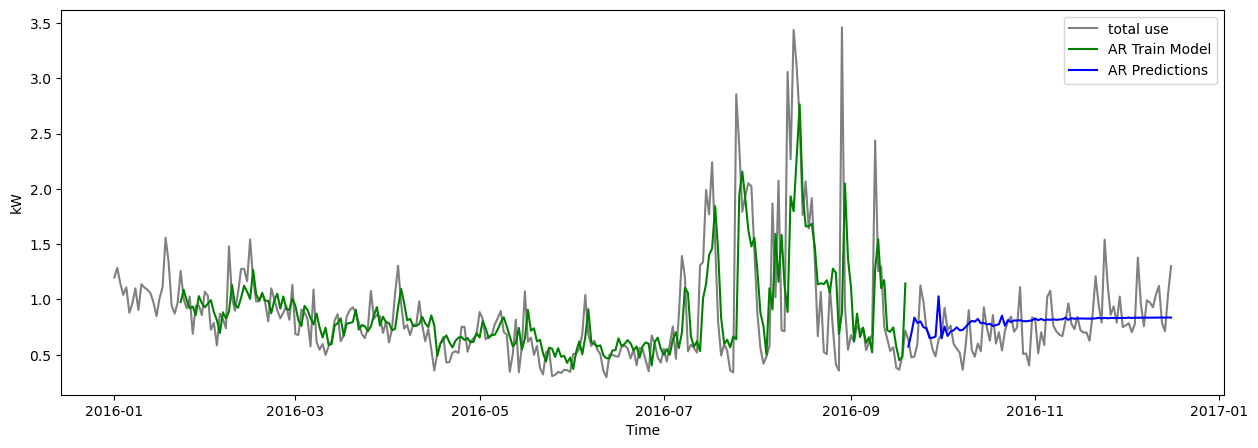

                            AutoReg Model Results                             
Dep. Variable:                    use   No. Observations:                  263
Model:             Restr. AutoReg(22)   Log Likelihood                -123.425
Method:               Conditional MLE   S.D. of innovations              0.404
Date:                Mon, 06 May 2024   AIC                            260.850
Time:                        18:49:26   BIC                            285.243
Sample:                    01-23-2016   HQIC                           270.677
                         - 09-19-2016                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1303      0.071      1.829      0.067      -0.009       0.270
use.L1         0.5039      0.062      8.166      0.000       0.383       0.625
use.L2         0.1467      0.061      2.400      0.0

,R2,MAE,MAPE,MSE,RMSE
0,0.089035,0.164315,23.036888,0.043566,0.208725


In [6]:
ar_model, ar_metrics = ar_baseline_model(train_data, test_data, use_data_daily, lags=[1,2,11,21,22])
ar_metrics

>##### **Observations** 
> * We observe that the AR model exhibits poor predictive performance with lags 1,2 and 11, indicated by a negative R-squared value (-0.122) and relatively high Mean Absolute Error (MAE) of 0.186 and Mean Absolute Percentage Error (MAPE) of 27.7%. While we could marginally enhance these metrics by incorporating additional lags, I opt against doing so, as it would only increase the complexity of the model without substantially improving its fit.
> * It seems that incorporating lags at intervals of 11 slightly enhances predictive power. Additionally, including some consecutive lags such as 1, 2, or 21, 22 also yields improvement.
> ##### **Impact**
> * Let's see how it behaves by implementing the moving average component and by ussing the difference data. To help the selection of values for this parameters i will plot the residuals of the predictions 

### *ARIMA model*

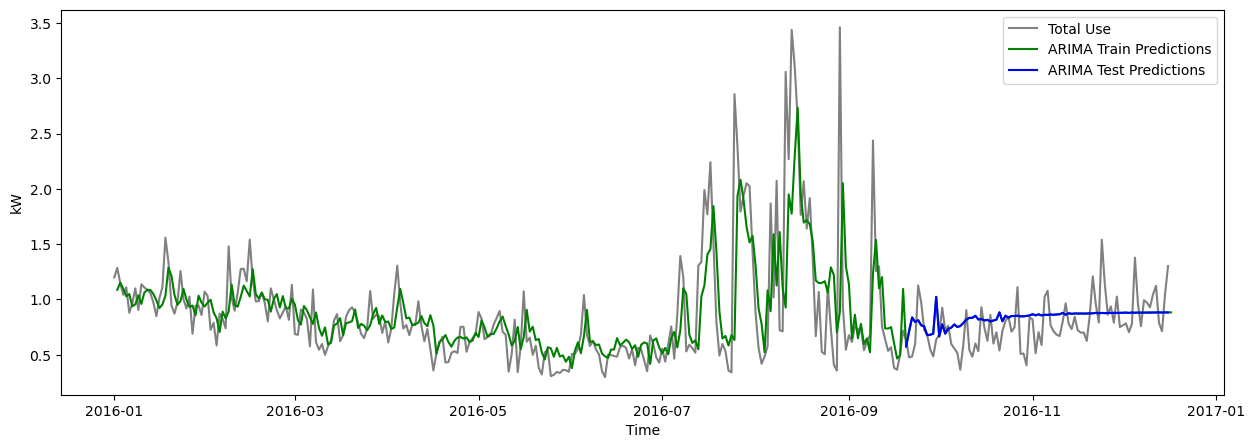

                                        SARIMAX Results                                         
Dep. Variable:                                      use   No. Observations:                  263
Model:             ARIMA([1, 2, 11, 21, 22], 0, [2, 7])   Log Likelihood                -126.099
Date:                                  Mon, 06 May 2024   AIC                            270.198
Time:                                          18:49:27   BIC                            302.348
Sample:                                      01-01-2016   HQIC                           283.118
                                           - 09-19-2016                                         
Covariance Type:                                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8859      0.260      3.412      0.001       0.377

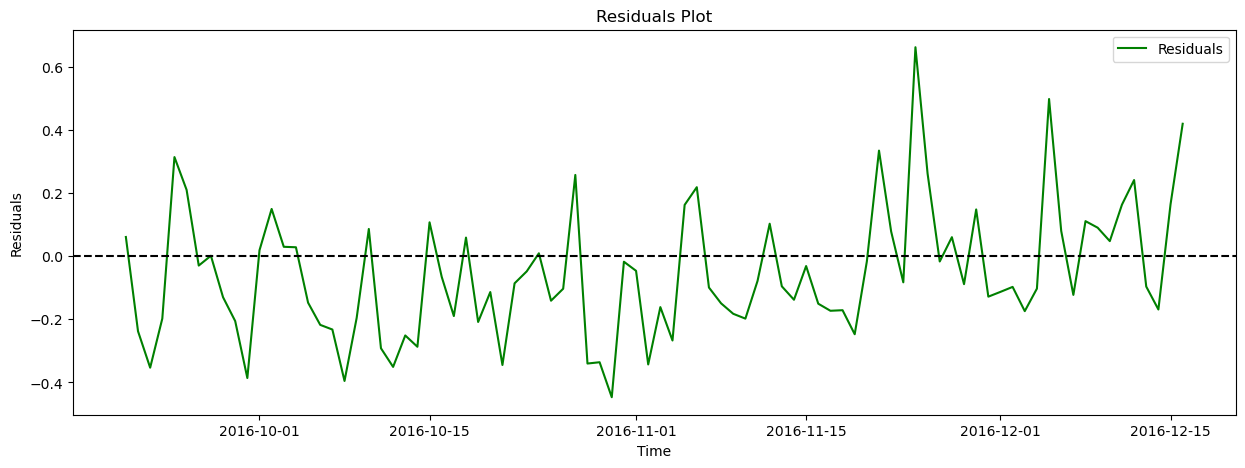

,R2,MAE,MAPE,MSE,RMSE
0,0.051575,0.17345,25.188613,0.045358,0.212974


In [7]:
arima,arima_metrics,arima_residuals = arima_model(train_data,test_data, use_data_daily,order=((1,2,11,21,22),0,(2,7)))
arima_metrics

> By using the moving average component we achieve worse metrics. Lets try with some transformation

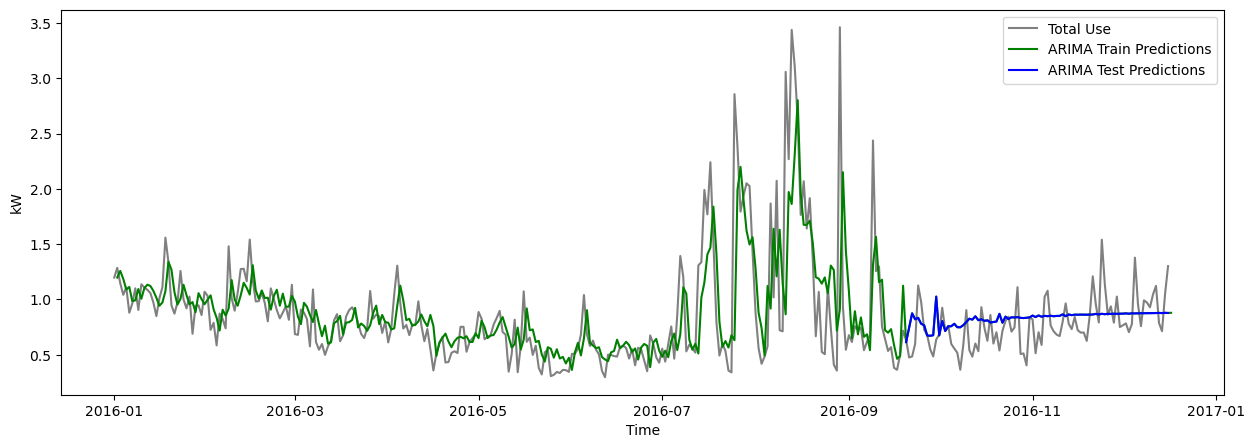

                                          SARIMAX Results                                          
Dep. Variable:                                         use   No. Observations:                  263
Model:             ARIMA([1, 2, 11, 21, 22], 1, [1, 2, 7])   Log Likelihood                -127.168
Date:                                     Mon, 06 May 2024   AIC                            272.336
Time:                                             18:49:29   BIC                            304.451
Sample:                                         01-01-2016   HQIC                           285.244
                                              - 09-19-2016                                         
Covariance Type:                                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4600      0.156      2.95

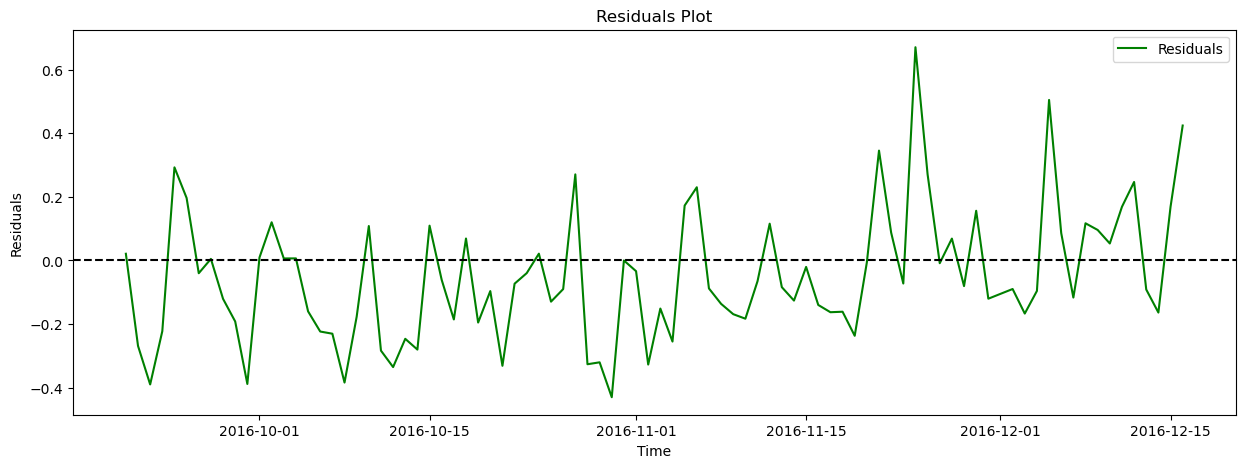

,R2,MAE,MAPE,MSE,RMSE
0,0.07089,0.169264,24.497366,0.044434,0.210794


In [8]:
arima,arima_metrics,arima_residuals = arima_model(train_data,test_data, use_data_daily, order=((1,2,11,21,22),1,(1,2,7)))
arima_metrics

> After abandoning this model, let's proceed with wrapped parameter tuning. I will explore potential seasonality possibilities and incorporate them into a seasonal ARIMA model.

In [9]:
#auto_arima = auto_arima(train_data, start_p=0, d=0, start_q=0, max_p=11, max_d=1, max_q=11,
                        #start_P=0, D=1, start_Q=0, max_P=11, max_D=1, max_Q=11, m=12, 
                        #seasonal=True, trace=True,stepwise=True)

#(1,0,1)(6,1,0)

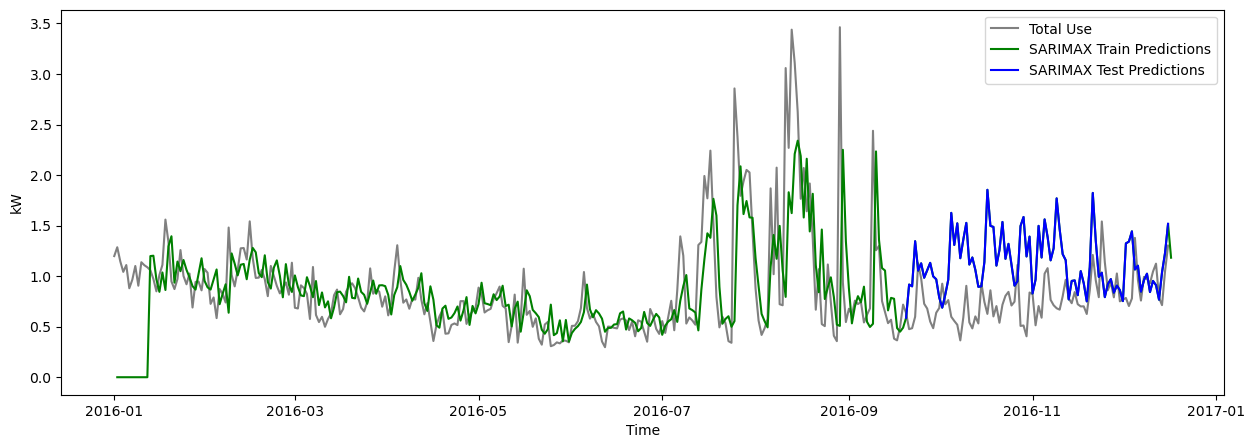

                                      SARIMAX Results                                      
Dep. Variable:                                 use   No. Observations:                  263
Model:             SARIMAX(1, 0, 1)x(6, 1, [], 12)   Log Likelihood                -155.987
Date:                             Mon, 06 May 2024   AIC                            329.975
Time:                                     18:49:43   BIC                            361.704
Sample:                                 01-01-2016   HQIC                           342.743
                                      - 09-19-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8056      0.046     17.431      0.000       0.715       0.896
ma.L1         -0.3186      

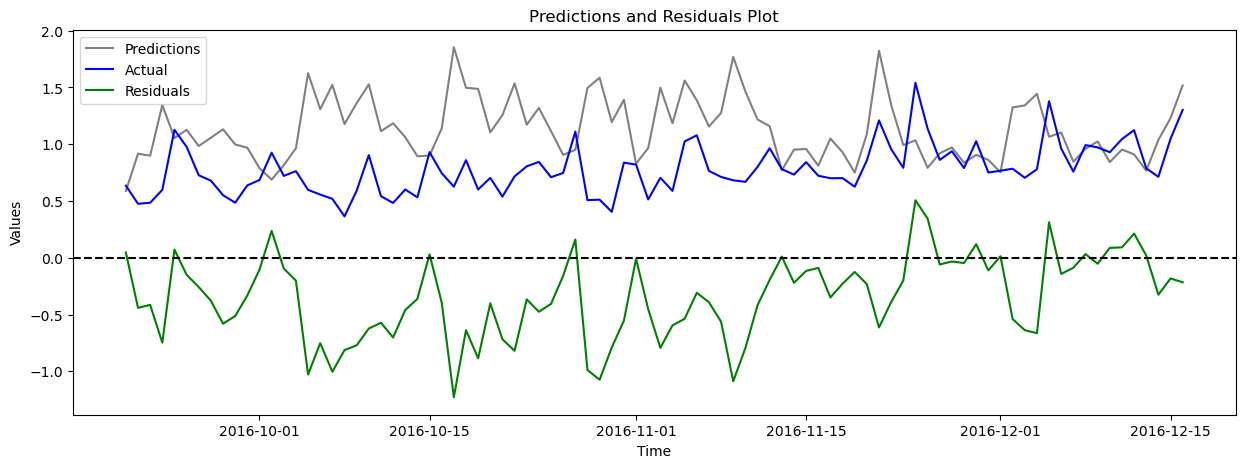

,R2,MAE,MAPE,MSE,RMSE
0,-4.258979,0.401026,61.591364,0.251507,0.501505


In [10]:
sarimax,sarimax_metrics = sarimax_model(train_data, test_data, use_data_daily, order=(1,0,1),seasonal_order=(6,1,0,12))
sarimax_metrics

> The model exhibits a satisfactory fit to the data, with notable coefficients for both autoregressive and moving average terms, along with seasonal terms at lags 12, 24, 36, 48, and 60. Despite this, its predictive performance for future values appears to be inadequate.

### **Multivariable Time-Series Prediction**

### **Feature Engineering**